# Análise de Negócios

## Preços dos combustíveis ofertados nos postos

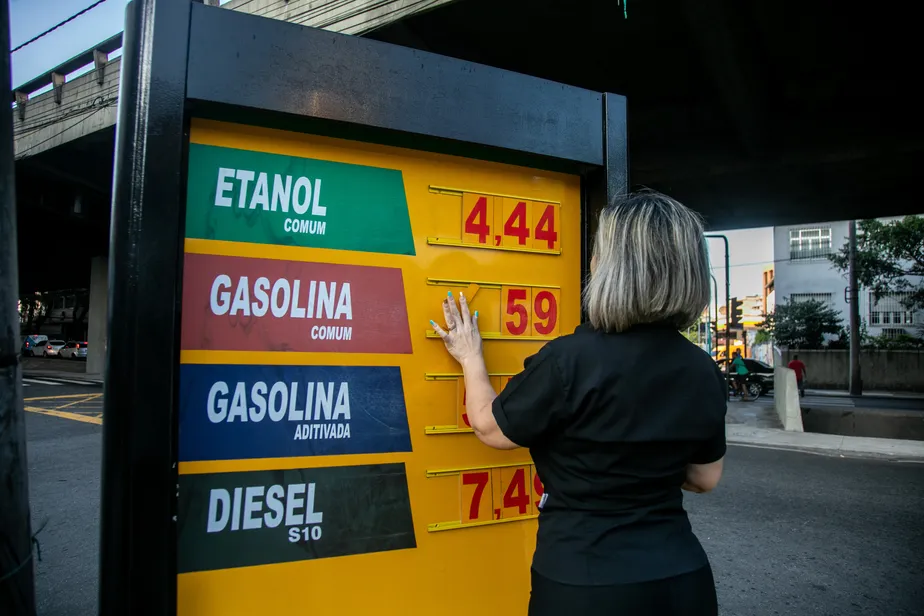

### Importação bibliotecas

In [2]:
# tratamento e manipulação dos dados
import pandas as pd
import numpy as np

# conexão com banco de dados
import pyodbc

import warnings
warnings.filterwarnings('ignore')

### Carregamento dos dados

In [3]:
# Parâmetros de conexão
server = 'DESKTOP-09VL69J'
database = 'anp_fiap'
driver = '{ODBC Driver 18 for SQL Server}'

# Conexão
dados_conexao = (
    f"DRIVER={driver};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"Trusted_Connection=yes;"
    f"TrustServerCertificate=yes;"
    f"Encrypt=yes;"
)

In [14]:
# Tentativa de conexão
try:
    conexao = pyodbc.connect(dados_conexao)
    print("Conexão bem-sucedida!")
except pyodbc.Error as e:
    print(f"Erro ao conectar ao banco de dados: {e}")
finally:
    # Verifica se a conexão foi criada antes de tentar fechar
    if 'conexao' in locals() and conexao:
        conexao.close()
        print("Conexão fechada.")

Conexão bem-sucedida!
Conexão fechada.


In [7]:
# criando conexao 
conexao = pyodbc.connect(dados_conexao)
cursor = conexao.cursor()

try:
    df = pd.read_sql("SELECT * FROM dados_anp", conexao)
except pyodbc.Error as e:
    # Captura erros relacionados ao banco de dados
    print(f"Erro na conexão com o banco de dados: {e}")
finally:
    cursor.close()
    conexao.close()

In [9]:
df.head(2)

,regiao,estado,municipio,Revenda,CNPJ,nome_rua,numero_rua,complemento,bairro,cep,produto,data_coleta,valor_venda,valor_compra,unidade_medida,bandeira
0,NE,BA,SALVADOR,PETROBRAS DISTRIBUIDORA S.A.,34.274.233/0015-08,RUA EDISTIO PONDE,474,NULL,STIEP,41770-395,GNV,2018-01-02,2.37,1.74,R$ / mÂ³,PETROBRAS DISTRIBUIDORA S.A.
1,NE,BA,SALVADOR,PETROBRAS DISTRIBUIDORA S.A.,34.274.233/0015-08,RUA EDISTIO PONDE,474,NULL,STIEP,41770-395,DIESEL S10,2018-01-02,3.24,3.14,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.


### Tratamento da base

In [30]:
# copia da base original para realizar os tratamentos e posteriormente a análise
dados_combustiveis = df.copy()

In [23]:
# exibindo a dimensão do df
print(f'Número de linhas: {dados_combustiveis.shape[0]:,}')
print(f'Número de colunas: {dados_combustiveis.shape[1]:,}')

Número de linhas: 5,782,524
Número de colunas: 16


In [24]:
# identificando dados vazios
dados_combustiveis.isnull().sum()

regiao            0
estado            0
municipio         0
Revenda           0
CNPJ              0
nome_rua          0
numero_rua        0
complemento       0
bairro            0
cep               0
produto           0
data_coleta       0
valor_venda       0
valor_compra      0
unidade_medida    0
bandeira          0
dtype: int64

In [25]:
# verificando os tipos de dados
dados_combustiveis.dtypes

regiao                    object
estado                    object
municipio                 object
Revenda                   object
CNPJ                      object
nome_rua                  object
numero_rua                object
complemento               object
bairro                    object
cep                       object
produto                   object
data_coleta       datetime64[ns]
valor_venda              float64
valor_compra             float64
unidade_medida            object
bandeira                  object
dtype: object

Os dados vieram de acordo com o banco, nenhum tratametno necessário

### Análise exploratória de dados

In [26]:
dados_combustiveis.columns

Index(['regiao', 'estado', 'municipio', 'Revenda', 'CNPJ', 'nome_rua',
       'numero_rua', 'complemento', 'bairro', 'cep', 'produto', 'data_coleta',
       'valor_venda', 'valor_compra', 'unidade_medida', 'bandeira'],
      dtype='object')

In [32]:
# adicionando informação de ano e mês
dados_combustiveis = dados_combustiveis.assign(
    ano=dados_combustiveis['data_coleta'].dt.year,
    mes=dados_combustiveis['data_coleta'].dt.month
)

# Selecionando as colunas necessárias
dados_combustiveis = dados_combustiveis[['ano', 'mes', 'data_coleta', 'regiao', 'estado', 'municipio', 'bandeira', 'produto', 'valor_venda', 'valor_compra']]

In [34]:
dados_combustiveis.head(2)

,ano,mes,data_coleta,regiao,estado,municipio,bandeira,produto,valor_venda,valor_compra
0,2018,1,2018-01-02,NE,BA,SALVADOR,PETROBRAS DISTRIBUIDORA S.A.,GNV,2.37,1.74
1,2018,1,2018-01-02,NE,BA,SALVADOR,PETROBRAS DISTRIBUIDORA S.A.,DIESEL S10,3.24,3.14


In [35]:
dados_combustiveis.describe().round(2)

,ano,mes,data_coleta,valor_venda,valor_compra
count,5782524.00,5782524.00,5782524,5782524.00,5782524.00
mean,2020.75,6.10,2021-03-17 23:05:01.169800704,4.69,0.52
min,2018.00,1.00,2018-01-01 00:00:00,1.76,0.00
25%,2019.00,3.00,2019-06-24 00:00:00,3.65,0.00
50%,2021.00,6.00,2021-05-03 00:00:00,4.50,0.00
75%,2022.00,9.00,2022-11-24 00:00:00,5.69,0.00
max,2024.00,12.00,2024-06-28 00:00:00,9.79,5.09
std,1.94,3.38,NaN,1.27,1.22


Parece que o campo valor de compra não esta corretamente preenchido

In [39]:
dados_combustiveis['valor_compra'].value_counts() / len(dados_combustiveis) * 100

valor_compra
0.00    84.014403
3.15     0.153895
3.10     0.145819
3.17     0.144608
3.13     0.138382
          ...    
1.28     0.000035
1.34     0.000035
4.97     0.000017
4.89     0.000017
5.09     0.000017
Name: count, Length: 358, dtype: float64

84% da base esta sem valor preenchido para coluna 'valor_compra', portanto vou excluir essa coluna do df

In [41]:
dados_combustiveis.drop(columns='valor_compra', inplace=True)

Quais são os produtos comercializados?

In [42]:
print(f'Os produtos comercializados são: {dados_combustiveis.produto.unique()}')

Os produtos comercializados são: ['GNV' 'DIESEL S10' 'ETANOL' 'GASOLINA' 'DIESEL' 'GASOLINA ADITIVADA']


Quais anos estão na base?

In [43]:
print(f'Os anos presentes na base são: {dados_combustiveis.ano.unique()}')

Os anos presentes na base são: [2018 2019 2020 2021 2022 2023 2024]


Visualizando os valores mínimos, médios e máximos por ano

In [51]:
dados_combustiveis.groupby(['produto', 'ano']).agg(
                                                    valor_venda_min=('valor_venda', 'min'),
                                                    valor_venda_max=('valor_venda', 'max'),
                                                    valor_venda_mean=('valor_venda', 'mean')
                                                ).round(2)

valor_venda_min  valor_venda_max  valor_venda_mean
produto            ano                                                     
DIESEL             2018             2.80             5.20              3.50
                   2019             2.87             4.99              3.60
                   2020             2.45             5.09              3.42
                   2021             3.10             6.99              4.69
                   2022             3.14             9.00              6.63
                   2023             3.97             7.99              5.76
                   2024             4.69             8.19              5.94
DIESEL S10         2018             2.84             5.30              3.59
                   2019             2.79             5.09              3.69
                   2020             2.46             5.38              3.51
                   2021             2.81             6.96              4.74
                   2022             3.59             9.65              6.73
                   2023             4.19             9.00              5.86
                   2024             4.99             8.89              6.00
ETANOL             2018             1.90             4.98              3.13
                   2019             2.10             5.47              3.17
                   2020             1.80             5.15              3.18
                   2021             2.05             7.90              4.67
                   2022             2.49             7.98              4.85
                   2023             2.69             6.96              4.00
                   2024             2.63             6.60              3.90
GASOLINA           2018             3.37             6.29              4.45
                   2019             3.39             6.29              4.42
                   2020             2.87             5.90              4.28
                   2021             3.10             8.00              5.89
                   2022             3.49             8.99              6.32
                   2023             4.09             8.19              5.53
                   2024             4.55             7.99              5.78
GASOLINA ADITIVADA 2020             3.69             6.00              4.59
                   2021             3.46             8.99              6.04
                   2022             4.09             9.28              6.47
                   2023             3.47             9.79              5.71
                   2024             4.69             8.89              5.97
GNV                2018             1.76             4.10              2.73
                   2019             2.00             4.56              3.22
                   2020             2.00             4.78              3.17
                   2021             2.38             6.70              3.89
                   2022             3.17             7.99              5.04
                   2023             2.39             6.71              4.64
                   2024             3.54             6.69              4.74